## Linear Causal Effects With Toy Data

This notebook demonstrates a procedure for calculating linear causal effects among three interdependent time series variables. The procedure consists of two phases. First, time-lagged causal links are identified using the PC-stable algorithm adapted for time series. Then, causal effects are quantified using a linear vector autoregressive (VAR) model. 

For simplicity and clarity, this demonstraton uses synthetic data with a known underlying causal structure, following Figure 4 of Kaufman, Zachary S., and Nicole Feldl. "Causes of the Arctic’s Lower-Tropospheric Warming Structure." Journal of Climate 35.6 (2022): 1983-2002. https://doi.org/10.1175/JCLI-D-21-0298.1. For more complex applications of the method, see *LinearCausalEffects_SeasonalClimateData.ipynb*

----------------------











In [43]:
%matplotlib inline
import numpy as np
import matplotlib
from tigramite import data_processing as pp
from tigramite import plotting as tp
from tigramite.pcmci import PCMCI
import sklearn
from tigramite.independence_tests import ParCorr
from tigramite.models import LinearMediation

### Causal Network Input

Consider data generated from a vector autoregressive (VAR) process with three variables and the following causal interdependencies: 

$X_{i}(t) = 0.7X_{i}(t-1) + \epsilon_{i}(t)$ <br>

$X_{k}(t) = 0.5X_{i}(t-1) + 0.6X_{k}(t-1)  + \epsilon_{k}(t)$ <br>

$X_{j}(t) = 0.6X_{i}(t-1) - 0.3X_{k}(t-1)  + 0.3X_{j}(t-1) + \epsilon_{j}(t)$ <br>

where $\epsilon(t)$ are independent, identically distributed error terms. 



(<Figure size 432x288 with 3 Axes>,
 array([<AxesSubplot:ylabel='$X_{i}$'>, <AxesSubplot:ylabel='$X_{k}$'>,
        <AxesSubplot:xlabel='time', ylabel='$X_{j}$'>], dtype=object))

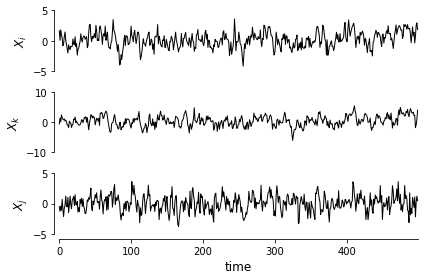

In [66]:
# simulate VAR process with 500 timesteps 

np.random.seed(1)
data = np.random.randn(500, 3)
for t in range(1, 500):
    # variable x_i
    data[t, 0] += 0.7*data[t-1, 0]
    # variable x_k
    data[t, 1] += 0.6*data[t-1, 1] + 0.5*data[t-1, 0]
    # variable x_j 
    data[t, 2] += 0.3*data[t-1, 2] - 0.3*data[t-1, 1] + 0.6*data[t-1, 0]
    
var_names = [r'$X_{i}$', r'$X_{k}$', r'$X_{j}$']
dataframe = pp.DataFrame(data, var_names=var_names)
tp.plot_timeseries(dataframe)

## Step 1: PC-Stable

We will now use the PC-algorithm to detect the underlying causal structure of the three simulated time series (see printed output below). For each input time series, the algorithm begins by calculating every possible time-lagged linear auto-correlation and cross-correlation over a pre-determined time window, or maximum lag ($\tau_\textrm{max}$). To test whether $X_{i}$ causes $X_{j}$, for instance, we calculate: 

$\rho(X_{i}(t-\tau),X_{j}(t))$

where $\rho$ is the Pearson correlation coefficient and $\tau$ is a time lag. Contemporaneous links are not considered here. The significance of $\rho$ is assessed with a pre-defined significance threshold, $\alpha$, and if $\rho$ is found to be insignificant, then we conclude that $X_{i}(t-\tau)$ does not cause $X_{j}(t)$ and remove it from the set of possible links. 

While $X_{i}(t-\tau)$  may be unconditionally correlated with $X_{j}(t)$, the relationship could be confounded by  the influence of another network variable. Therefore, after the initial lagged correlation test, the PC-algorithm tests the remaining significant links a second time, conditioned on the influence of a third process, $Z_{1}$:

$\rho(X_{i}(t-\tau),X_{j}(t) | Z_{1})$

where $Z_{1} \neq  X_{i}(t-\tau)$ is the auto or cross-link possessing the strongest unconditional correlation with $X_{j}(t)$ in the unconditional indepdendence test. The vertical line denotes removing the linear influence of $Z_{1}$ from both $X_{i}(t-\tau)$ and $X_{j}(t)$ and testing the correlation between their residuals. If $Z_{1}$ makes the formerly significant link insignificant, the two variables are said to be conditionally independent, and the link is subsequently removed. This process is repeated over $n$ iterations by adding an increasingly stringent number of conditions, $Z_2,\,Z_3,\,...\,,Z_n$ to the partial correlation tests until no more links can be removed. The PC-algorithm finishes when it converges to a final set of significant links for each variable, which are subsequently considered the causes of $X_{j}(t)$.

In [67]:
# Detect parents of each variable using PC-stable with alpha = .01 and tau_max = 3 

parcorr = ParCorr()
pcmci_parcorr = PCMCI(
    dataframe=dataframe, 
    cond_ind_test=parcorr,
    verbosity=2)
all_parents = pcmci_parcorr.run_pc_stable(tau_max=3, pc_alpha=.01)


##
## Step 1: PC1 algorithm with lagged conditions
##

Parameters:
independence test = par_corr
tau_min = 1
tau_max = 3
pc_alpha = [0.01]
max_conds_dim = None
max_combinations = 1



## Variable $X_{i}$

Iterating through pc_alpha = [0.01]:

# pc_alpha = 0.01 (1/1):

Testing condition sets of dimension 0:

    Link ($X_{i}$ -1) --> $X_{i}$ (1/9):
    Subset 0: () gives pval = 0.00000 / val =  0.653
    No conditions of dimension 0 left.

    Link ($X_{i}$ -2) --> $X_{i}$ (2/9):
    Subset 0: () gives pval = 0.00000 / val =  0.414
    No conditions of dimension 0 left.

    Link ($X_{i}$ -3) --> $X_{i}$ (3/9):
    Subset 0: () gives pval = 0.00000 / val =  0.271
    No conditions of dimension 0 left.

    Link ($X_{k}$ -1) --> $X_{i}$ (4/9):
    Subset 0: () gives pval = 0.00000 / val =  0.251
    No conditions of dimension 0 left.

    Link ($X_{k}$ -2) --> $X_{i}$ (5/9):
    Subset 0: () gives pval = 0.00010 / val =  0.174
    No conditions of dimension 0 left.

    Link ($X_{k}$ -3)

The output from PC-stable highlights the importance of conditional independence testing. $X_{j}$, for instance, is found to be unconditionally dependent on lagged values at $\tau$ = 2 and $\tau$ =3. However, after adding two conditions, such links are eliminated, and the algorithm converges on three parents for $X_{j}$ exclusively at $\tau$ = 1, which is the correct causal structure. 

---------

### Parameter Selection ($\alpha$ and $\tau_{max}$):

The above example uses somewhat arbitrary values for $\alpha$ and $\tau_{max}$, but the choice of which value to use can be important. The strictness of the significance threshold, $\alpha$, can follow user preferences favoring network connectivity vs. network simplicity. For a more objective approach, setting pc_alpha = None will test a range of $\alpha$ and select values that minimizes the Akaikie Information criterion (AIC) among the associated linear models.

A reasonable choice for maximum lag ($\tau_{max}$) can be inferred by visually examining the partial autocorrelation functions (PACF) associated with each variable.

 

---------

## Step 2: Causal Effect Calculation 

To calculate causal effects, we first fit a multivariate linear lagged regression model (i.e. a VAR model) to the input time series, where the associated regression coefficients are set to zero for all links except those deemed significant by the PC-algorithm in step 1. The coeffcient estimations shown below are consistent with the underlying data generating process specified at the start of this notebook. 

In [68]:
med = LinearMediation(dataframe=dataframe)
med.fit_model(all_parents=all_parents,tau_max=3) 
coefficients = med.get_val_matrix() # shape N,N tau_max +1, where N is the number of variables 
print('Lag-1 Linear regression coefficients (i.e., link coefficients) fit to parents')
print('')
print('X_{i}',coefficients[:,0,1])
print('X_{k}',coefficients[:,1,1])
print('X_{j}',coefficients[:,2,1])


Lag-1 Linear regression coefficients (i.e., link coefficients) fit to parents

X_{i} [0.65287075 0.         0.        ]
X_{k} [0.42415763 0.53601858 0.        ]
X_{j} [ 0.55968534 -0.37190044  0.26602864]


Original data generating process:

$X_{i}(t) = 0.7X_{i}(t-1) + \epsilon_{i}(t)$ <br>

$X_{k}(t) = 0.5X_{i}(t-1) + 0.6X_{k}(t-1)  + \epsilon_{k}(t)$ <br>

$X_{j}(t) = 0.6X_{i}(t-1) - 0.3X_{k}(t-1)  + 0.3X_{j}(t-1) + \epsilon_{j}(t)$ <br>

Here, an individual regression coefficient, or link coefficient, indicates the expected change in a variable at time $t$ caused by a hypothetical $1\sigma$ perturbation in one of the variable's parents at $t - 1$, with all other variables held constant. Note that $\tau_{max}$ for the estimated VAR model is unrestricted, and can be user-specified according to their time horizon of interest. In other words, even though individual regression coefficients are only found to be significant at $\tau$ = 1, we can still use this model to calculate causal effects at larger lags (up to $\tau_{max} = 3$, in this case). 

---------------

### Total Causal Effect and Mediated Causal Effect

The total causal effect of any hypothetical perturbation over a user-defined time domain is calculated by iteratively computing link coefficient matrix products from the estimated VAR model. The total causal effect can be thought of as an impulse response function, or quasi-Green's function. For instance, the total causal effect of $X_{i}(t-2)$ on $X_{j}(t)$ is the sum of each coefficient pathway shown below in the time series graph visual. 

Total Causal effect (X_{i}(t-2) --> (X_{j}(t):  0.3565501046840963


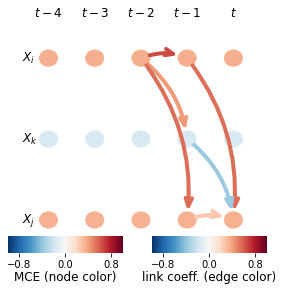

In [70]:
graph_data = med.get_mediation_graph_data(i=0, tau=2, j=2)
print ("Total Causal effect (X_{i}(t-2) --> (X_{j}(t): ", med.get_ce(i=0, tau=-2, j=2))
tp.plot_mediation_time_series_graph(
    figsize=[4.0,4.0],
    var_names=var_names,
    node_ticks = 0.8,
    edge_ticks = 0.8,
    path_node_array=graph_data['path_node_array'],
    tsg_path_val_matrix=graph_data['tsg_path_val_matrix'],
    )

Mediated causal effect (MCE) is the portion of the total causal effect mediated by an individual variable. For instance, the blue node color of $X_{k}$ reflects that the link coefficient pathway through $X_{k}$ is negative (positive link coefficient multiplied by negative link coefficient), indicating that the mediating impact of $X_{k}$ reduces the magnitude of the total causal effect, which is of opposite sign. 





In [71]:
print ("Mediated Causal effect (X_{i}(t-2) --> (X_{j}(t) through X_{k}: ", med.get_mce(i=0, tau=-2, j=2,k=1))


Mediated Causal effect (X_{i}(t-2) --> (X_{j}(t) through X_{k}:  -0.15774441209363987


Since all link coefficients in this VAR process are $<$1, total causal effects tend to get smaller at larger lags (see below). 

Total Causal effect (X_{i}(t-3) --> (X_{j}(t):  0.1458722894220579


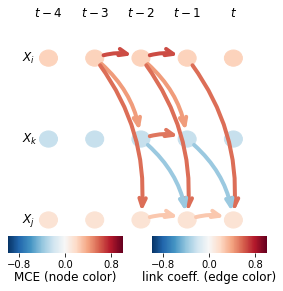

In [72]:
graph_data = med.get_mediation_graph_data(i=0, tau=3, j=2)
print ("Total Causal effect (X_{i}(t-3) --> (X_{j}(t): ", med.get_ce(i=0, tau=-3, j=2))
tp.plot_mediation_time_series_graph(
    figsize=[4.0,4.0],
    var_names=var_names,
    node_ticks = 0.8,
    edge_ticks = 0.8,
    path_node_array=graph_data['path_node_array'],
    tsg_path_val_matrix=graph_data['tsg_path_val_matrix'],
    )